# Attentive Knowledge Tracing (AKT)

This model is based on the paper called *Context-Aware Attentive Knowledge Tracing* by Ghosh et al. (2020). The model is designed to predict the probability of a student answering a question correctly based on their past performance and the context of the question. Extends Self-Attentive Knowledge Tracing (SAKT) with an architecture that combines dynamic memory and attention mechanisms.

**Outline:**
1. **Introduction**
2. **Imports & Data Loading**  
3. **Data Preprocessing** 
4. **Sequence Generator**  
5. **Build AKT Model**  
6. **Training Loop**  
7. **Validation**  
8. **Test Set Evaluation**  
9. **Analysis & Visualization**  
10. **Conclusion**

In [ ]:
# Install required libraries (uncomment if running outside Docker)
# !pip install --quiet -r requirements_colab.txt

## 1. Introduction

Attentive Knowledge Tracing (AKT) is a transformer-based architecture designed to model how students acquire and apply knowledge over time. It improves upon earlier models like Deep Knowledge Tracing (DKT) and SAKT by introducing mechanisms to capture **temporal decay**, **semantic similarity**, and **question difficulty** in a unified framework.

### Key Innovations

AKT introduces two main architectural enhancements:

1. **Monotonic Attention with Temporal Biases**: Rather than treating all past interactions equally, AKT uses an attention mechanism that decays over time and emphasizes semantically similar events. This better reflects real-world memory processes (e.g., forgetting, reinforcement through repetition).

2. **Context-Aware Embedding Parameterization**: Inspired by Item Response Theory (IRT), AKT represents questions not only by their identity, but also by their associated concepts and difficulty, enabling generalization to unseen or rare questions.


### Problem Setting

Let a student have a history of interactions:

$$
\mathcal{S}_t = \left\{(q_1, r_1), (q_2, r_2), \dots, (q_t, r_t)\right\}
$$

where:

- $q_t \in \mathcal{Q}$ is the question identifier,
- $r_t \in \{0,1\}$ indicates whether the student answered correctly.

Each $(q_t, r_t)$ pair is encoded into an interaction embedding:

$$
x_t = \text{Emb}_q(q_t) + \text{Emb}_r(r_t) \in \mathbb{R}^d
$$

The sequence of past interactions is then processed by **contextual encoders** (stacked self-attention layers), producing:

- $\hat{x}_t = \text{ContextualizedQuestion}(x_{1:t})$
- $\hat{y}_{1:t-1} = \text{ContextualizedKnowledge}(y_{1:t-1})$

These representations allow the model to account for how past experiences shape current understanding.


### Attention with Context-Aware Decay

To compute the influence of past steps on the current prediction, AKT uses an attention mechanism modified to include **temporal decay** and **semantic distance**.

For each past time step $\tau < t$, the attention score is:

$$
s_{t,\tau} = \exp\left(-\theta \cdot d(t,\tau)\right) \cdot \frac{q_t^\top k_\tau}{\sqrt{D_k}},
$$

where:

- $\theta > 0$ is a learned decay rate,
- $q_t$ and $k_\tau$ are the query and key vectors for the current and past steps,
- $d(t, \tau)$ is a **context-sensitive time distance** given by:

$$
d(t, \tau) = |t - \tau| \cdot \sum_{t'=\tau+1}^{t} \gamma_{t,t'}
$$

with:

$$
\gamma_{t,t'} = \frac{\exp\left(q_t^\top k_{t'} / \sqrt{D_k}\right)}{\sum_{\tau'} \exp\left(q_t^\top k_{\tau'} / \sqrt{D_k}\right)}
$$

These weights ensure that interactions that are both **recent** and **relevant** receive higher attention.

The final attention weights are:

$$
\alpha_{t,\tau} = \frac{\exp(s_{t,\tau})}{\sum_{\tau'} \exp(s_{t,\tau'})}
$$

and the **knowledge vector** is computed as:

$$
h_t = \sum_{\tau=1}^{t-1} \alpha_{t,\tau} \cdot v_\tau
$$

where $v_\tau$ is the value vector derived from $\hat{y}_\tau$.

As a general form, this mechanism is aligned with the transformer attention:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d}} + B\right)V
$$

where $B$ encodes learned **temporal bias terms** based on relative time gaps between events.


### Rasch-Based Embeddings

AKT also addresses the challenge of large question vocabularies by decomposing question embeddings into interpretable components:

$$
x_t = c_{c_t} + \mu_{q_t} \cdot d_{c_t}
$$

$$
y_t = e(c_t, r_t) + \mu_{q_t} \cdot f(c_t, r_t)
$$

where:

- $c_{c_t}$: base concept embedding (e.g., "fractions", "geometry"),
- $d_{c_t}$: difficulty direction vector for the concept,
- $\mu_{q_t}$: scalar difficulty of question $q_t$ (learned),
- $e, f$: embeddings dependent on concept and correctness.

This **concept-aware formulation** allows the model to generalize across questions linked to the same underlying skill, while capturing difficulty via the Rasch parameter $\mu_{q_t}$.


### Prediction Layer

The final output is produced by concatenating the current knowledge vector $h_t$ and the current question embedding $x_t$, and passing them through a multi-layer perceptron:

$$
\hat{r}_{t+1} = \sigma\left(f\left([h_t; x_t]\right)\right)
$$

This represents the probability that the student will answer the next question correctly.

The model is trained end-to-end using the binary cross-entropy loss:

$$
\mathcal{L} = -\sum_t \left[r_t \log \hat{r}_t + (1 - r_t) \log(1 - \hat{r}_t)\right]
$$


### Summary of Contributions

- **Temporal dynamics**: through decay-aware monotonic attention.
- **Semantic alignment**: via content-aware similarity scores.
- **Efficient generalization**: enabled by Rasch-style concept embeddings.
- **Interpretability**: attention weights and difficulty scores are human-readable.

In the next sections, we implement AKT using TensorFlow/Keras, train it on a cleaned interaction dataset, and evaluate its performance across multiple metrics.

## 2. Imports & Data Loading

We import necessary libraries and load the preprocessed data.

In [ ]:
# Silence TensorFlow logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Core packages
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
from keras.initializers import Constant
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
# Visualization
import matplotlib.pyplot as plt


# -------------- Comment out the following lines if you are running in Google Colab --------------
# Paths
base_path = os.path.join("..", "..", "Data_Preprocessing", "data")
splits_path = os.path.join(base_path, "splits")
# Load data
train_df = pd.read_parquet(os.path.join(splits_path, "train.parquet"))
val_df   = pd.read_parquet(os.path.join(splits_path, "val.parquet"))
test_df  = pd.read_parquet(os.path.join(splits_path, "test.parquet"))
questions_df = pd.read_parquet(os.path.join(base_path, "questions_clean.parquet"))
quizzes_df   = pd.read_parquet(os.path.join(base_path, "quizzes_clean.parquet"))


# -------------- Uncomment the following lines if you are running in Google Colab --------------
# Note: don't forget to add the files train.parquet, val.parquet, test.parquet, quizzes_clean.parquet
# questions_clean.parquet and best_params.txt to the data folder named "data".
# train_df = pd.read_parquet("data/train.parquet")
# val_df   = pd.read_parquet("data/val.parquet")
# test_df  = pd.read_parquet("data/test.parquet")
# questions_df = pd.read_parquet("data/questions_clean.parquet")
# quizzes_df   = pd.read_parquet("data/quizzes_clean.parquet")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (420867, 15)
Validation shape: (89809, 15)
Test shape: (92496, 15)


## 3. Data Preprocessing

In this section, we will prepare our raw interaction records for model training by:

1. **Loading** the three splits (*train.parquet*, *val.parquet*, *test.parquet*) and question/quiz metadata.
2. **Merging** question and quiz details into each interaction, then dropping any rows missing critical fields (e.g. category).
3. **Encoding** categorical identifiers:
   - Map each *question_id* → contiguous integer in *[0, E)*.
   - Map each *quiz_id*   → contiguous integer in *[0, Qz)*.
   - Map each question’s *general_cat* → integer in *[0, C)*.
4. **Computing** two kinds of time‐since‐last features:
   - *prev_time_quiz*: elapsed seconds since the student’s previous attempt on **any** quiz, then standardized **per user** to avoid leakage.
   - *cum_attempts*: cumulative count of attempts per user (optional, may help some architectures).
5. **Casting** the *correct* flag to a binary integer and inspecting the enriched DataFrame.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Merge question metadata
train_df = train_df.merge(questions_df[['id','category','general_cat']], 
                          left_on='question_id', right_on='id', how='left').dropna(subset=['category'])
val_df   = val_df.merge(questions_df[['id','category','general_cat']], 
                        left_on='question_id', right_on='id', how='left').dropna(subset=['category'])
test_df  = test_df.merge(questions_df[['id','category','general_cat']], 
                         left_on='question_id', right_on='id', how='left').dropna(subset=['category'])

# Build encoders for question_id and quiz_id
qid_encoder = LabelEncoder().fit(train_df['question_id'])
train_df['q_idx'] = qid_encoder.transform(train_df['question_id'])
val_df['q_idx']   = qid_encoder.transform(val_df['question_id'])
test_df['q_idx']  = qid_encoder.transform(test_df['question_id'])
E = len(qid_encoder.classes_)  # number of unique questions

quiz_encoder = LabelEncoder().fit(train_df['quiz_id'])
train_df['quiz_idx'] = quiz_encoder.transform(train_df['quiz_id'])
val_df['quiz_idx']   = quiz_encoder.transform(val_df['quiz_id'])
test_df['quiz_idx']  = quiz_encoder.transform(test_df['quiz_id'])
Qz = len(quiz_encoder.classes_)
# Rasch embeddings concept gallery
concepts = questions_df['general_cat'].unique()
concept_encoder = LabelEncoder().fit(concepts)
train_df['c_idx'] = concept_encoder.transform(train_df['general_cat'])
val_df['c_idx']   = concept_encoder.transform(val_df['general_cat'])
test_df['c_idx']  = concept_encoder.transform(test_df['general_cat'])
C = len(concept_encoder.classes_)  # number of concepts

# Compute and standardize time-since-last-quiz per user.
for df in [train_df, val_df, test_df]:
    df.sort_values(['user_id','start_time'], inplace=True)
    # Compute time since last quiz
    df['prev_time_quiz'] = (
        df.groupby('user_id')['start_time']
          .diff()
          .dt.total_seconds()
          .fillna(0)
    )
    # Normalization per user (avoids data leakage)
    df['cum_attempts'] = df.groupby('user_id').cumcount() + 1
    df['prev_time_quiz'] = df.groupby('user_id')['prev_time_quiz'].transform(
        lambda x: (x - x.mean()) / x.std()
    ).fillna(0)

# Ensure correct flag is 0/1
for df in [train_df,val_df,test_df]:
    df['correct_flag'] = df['correct'].astype(int)

# Quick sanity check
print(f"# unique questions = {E}, # unique quizzes = {Qz}")
display(train_df[train_df['prev_time_quiz'] != 0.0].head(10))


# unique questions = 1739, # unique quizzes = 87


,id_x,created_at,updated_at,user_id,start_time,end_time,question_id,score,not_focus_duration,correct,...,difficulty,duration_s,id_y,category,general_cat,q_idx,quiz_idx,c_idx,prev_time_quiz,cum_attempts
0,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,3,1,0,True,...,0.676671,961,3,c,C,0,0,0,-0.084819,1
1,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,4,0,0,False,...,0.408553,961,4,c,C,1,0,0,-0.084819,2
2,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,5,0,0,False,...,0.603550,961,5,c,C,2,0,0,-0.084819,3
3,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,6,1,0,True,...,0.755121,961,6,c,C,3,0,0,-0.084819,4
4,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,7,0,0,False,...,0.530724,961,7,c,C,4,0,0,-0.084819,5
5,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,8,0,0,False,...,0.858898,961,8,c,C,5,0,0,-0.084819,6
6,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,9,-1,0,False,...,0.811475,961,9,c,C,6,0,0,-0.084819,7
7,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,10,1,0,True,...,0.535096,961,10,c,C,7,0,0,-0.084819,8
8,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,11,0,0,False,...,0.443684,961,11,c,C,8,0,0,-0.084819,9
9,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,12,0,0,False,...,0.436131,961,12,c,C,9,0,0,-0.084819,10


The previous output confirms that our encodings and time‐features have been correctly merged and normalized.

In [ ]:
# Normalize continuous features
from sklearn.preprocessing import RobustScaler

# Continuous columns to be scaled
cont_cols = ['difficulty', 'duration_s', 'prev_time_quiz']

# We adjust the climber with the training set only.
scaler = RobustScaler().fit(train_df[cont_cols])

# Transform train, val and test
for df in [train_df, val_df, test_df]:
    df[cont_cols] = scaler.transform(df[cont_cols])

# Sanity check
display(train_df[cont_cols].describe().loc[['min','25%','50%','75%','max']])

,difficulty,duration_s,prev_time_quiz
min,-1.059880,-1.206175,-1.564555
25%,-0.491833,-0.426295,-0.106286
50%,0.000000,0.000000,0.000000
75%,0.508167,0.573705,0.893714
max,1.407867,19.338645,198.826619


All three continuous features are now centered on 0 with reasonable spread, ready for neural input.

## 4. Sequence Generator

In this section, we build a custom *Sequence* for Keras that:

1. **Groups** interactions by *user_id* and orders by *start_time*.
2. **Slides** a window of length *max_len* over each user’s history:
   - **X**: input tensor of shape *(batch, max_len, 6)* containing
     1. *q_idx*  
     2. *quiz_idx*  
     3. *difficulty*  
     4. *prev_time_quiz*  
     5. *c_idx*  
     6. *correct_flag*  
   - **M_mask**: boolean mask *(batch, max_len)* indicating valid steps.
   - **Y**: next‐step label (the final *correct_flag*).

**Note**: We reset the index on each user’s sorted DataFrame so that slicing with *.iloc* is always consistent.


In [ ]:

class AKTSequence(Sequence):
    """
    Keras Sequence for AKT model.
    This class is used to generate batches of data for training and evaluation.
    It handles the user sequences and prepares the input data for the model.
    """
    def __init__(self, df, max_len=100, batch_size=64):
        """ Initialize the sequence with a DataFrame, max_len and batch_size.
        Args:
            df (pd.DataFrame): DataFrame containing the data.
            max_len (int): Maximum length of sequences.
            batch_size (int): Size of each batch.
        """
        self.df = df
        self.max_len = max_len
        self.batch_size = batch_size
        # Precompute per-user sequences with reset index
        self.user_ids = df['user_id'].unique()
        self.groups = {u: df[df['user_id']==u].sort_values('start_time').reset_index(drop=True)
                       for u in self.user_ids}

    def __len__(self):
        """ Returns the number of batches per epoch. """
        return int(np.ceil(len(self.user_ids)/self.batch_size))

    def __getitem__(self, idx):
        """
        Generates one batch of data.
        Args:
            idx (int): Index of the batch.
        Returns:
            tuple: A tuple containing the input data and labels.
        """
        # Select batch of users
        batch_users = self.user_ids[idx*self.batch_size : (idx+1)*self.batch_size]
        B = len(batch_users)

        # Allocate arrays
        X_q      = np.zeros((B, self.max_len), dtype=np.int32)
        X_quiz   = np.zeros((B, self.max_len), dtype=np.int32)
        X_diff   = np.zeros((B, self.max_len), dtype=np.float32)
        X_ptquiz = np.zeros((B, self.max_len), dtype=np.float32)
        X_c      = np.zeros((B, self.max_len), dtype=np.int32)
        X_corr   = np.zeros((B, self.max_len), dtype=np.int32)
        M_mask   = np.zeros((B, self.max_len), dtype=np.float32)
        Y        = np.zeros((B,), dtype=np.int32)

        batch_i = 0
        for u in batch_users:
            user_seq = self.groups[u]
            L = len(user_seq)
            if L < 2:
                continue

            # Extract history (all but last) and label (last)
            start = max(0, L-1-self.max_len)
            hist  = user_seq.iloc[start : L-1]
            T     = hist.shape[0]
            if T == 0:
                continue

            # Fill features into the last T positions
            X_q[batch_i,    -T:] = hist['q_idx'].values
            X_quiz[batch_i, -T:] = hist['quiz_idx'].values
            X_diff[batch_i, -T:] = hist['difficulty'].values
            X_ptquiz[batch_i,-T:] = hist['prev_time_quiz'].values
            X_c[batch_i,    -T:] = hist['c_idx'].values
            X_corr[batch_i, -T:] = hist['correct_flag'].values
            M_mask[batch_i,  -T:] = 1.0

            Y[batch_i] = user_seq.loc[L-1, 'correct_flag']
            batch_i += 1

        # Handle empty batch
        if batch_i == 0:
            return [np.zeros((1,self.max_len,6),dtype=np.float32),
                    np.zeros((1,self.max_len),dtype=bool)], np.zeros((1,),dtype=np.float32)

        # Stack and trim to actual batch_i
        X = np.stack([
                X_q[:batch_i],
                X_quiz[:batch_i],
                X_diff[:batch_i],
                X_ptquiz[:batch_i],
                X_c[:batch_i],
                X_corr[:batch_i],
            ], axis=-1).astype(np.float32)

        M_mask = M_mask[:batch_i].astype(bool)
        Y      = Y[:batch_i].astype(np.float32)

        return [X, M_mask], Y


What this previous code does:

- Loops over each user in the batch.
- Skips users with fewer than 2 interactions.
- Slices their history (up to *max_len*) for features and uses the final interaction as the label.
- Pads sequences to fixed length, fills the mask, and returns *[X, mask], Y* batches.
- If no valid users are found in a batch, it returns a dummy batch to avoid breaking training.


## 5. Build AKT Model

In this section, we implement the AKT model. This model learns both **question-aware** and **response-aware** representations via two parallel Transformer-based encoders.  

Key components:

1. **Rasch Embeddings**:
   - Combine per-concept embeddings and question-specific difficulty parameters (Rasch model).
2. **Monotonic Attention**:
   - A variant of self-attention that adds time-aware constraints via distance-aware decay.
3. **Two Encoders**:
   - One for question sequences, another for response sequences (using student correctness).
4. **Retriever Layer**:
   - Applies cross-attention from questions to encoded responses.
5. **Prediction**:
   - Combines the final question and retrieved response vectors to estimate *P(correct)* for the next question.

We compile the model using **binary crossentropy**, **Adam optimizer**, and track **AUC** and **accuracy** during training.


### Custom MonotonicAttention Layer

This cell defines the *MonotonicAttention* class, a custom attention mechanism that includes:

- Scaled dot-product attention over multiple heads.
- **Context-aware temporal decay** via trainable parameters (*theta*) applied to a soft attention-weighted time distance.
- **Causal masking** to prevent future information leakage.

This mechanism allows AKT to favor more temporally recent and semantically similar interactions.


In [ ]:
class MonotonicAttention(Layer):
    """ Monotonic Attention Layer.
    This layer implements a variant of the attention mechanism that incorporates
    temporal information into the attention scores. It uses a decay factor to
    control the influence of past time steps on the current attention scores.
    """
    def __init__(self, d_model, n_heads, init_theta=0.1, **kwargs):
        """
        Initialize the Monotonic Attention layer.
        Args:
            d_model (int): Dimension of the model.
            n_heads (int): Number of attention heads.
            init_theta (float): Initial value for the decay factor.
            **kwargs: Additional arguments for the Layer class.
        """
        super().__init__(**kwargs)
        self.d_model = d_model
        self.n_heads = n_heads
        self.init_theta = init_theta
        self.head_dim = d_model // n_heads
        
    def build(self, input_shape):
        """ Create the weights for the layer.
        Args:
            input_shape (tuple): Shape of the input tensor.
        """
        self.theta = self.add_weight(
            name='theta',
            shape=(self.n_heads,),
            initializer=Constant(self.init_theta),
            trainable=True
        )
        
        self.q_proj = Dense(self.d_model)
        self.k_proj = Dense(self.d_model)
        self.v_proj = Dense(self.d_model)
        
    def call(self, queries, keys, values, timesteps, mask=None):
        """
        Forward pass of the layer.
        Args:
            queries (tf.Tensor): Queries tensor of shape [B, T, D].
            keys (tf.Tensor): Keys tensor of shape [B, T, D].
            values (tf.Tensor): Values tensor of shape [B, T, D].
            timesteps (tf.Tensor): Timesteps tensor of shape [B, T].
            mask (tf.Tensor): Optional mask tensor of shape [B, T].
        Returns:
            tf.Tensor: Output tensor of shape [B, T, D].
        """
        batch_size = tf.shape(queries)[0]
        
        # Projection and division into heads
        Q = self.q_proj(queries)  # [B, T, D]
        K = self.k_proj(keys)     # [B, T, D]
        V = self.v_proj(values)   # [B, T, D]
        
        # Reshape [B, T, n_heads, head_dim]
        Q = tf.reshape(Q, [batch_size, -1, self.n_heads, self.head_dim])
        K = tf.reshape(K, [batch_size, -1, self.n_heads, self.head_dim])
        V = tf.reshape(V, [batch_size, -1, self.n_heads, self.head_dim])
        
        # Transpose to [B, n_heads, T, head_dim]
        Q = tf.transpose(Q, [0, 2, 1, 3])
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        
        # Calculate scaled similarity
        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))  # [B, n_heads, T, T]
        
        # Calculation of time difference
        t = tf.cast(timesteps, tf.float32)  # [B, T]
        time_diff = tf.abs(t[:, None, :, None] - t[:, None, None, :])  # [B, 1, T, T]
        
        # Gamma (softmax on original scores)
        gamma = tf.nn.softmax(scores, axis=-1)  # [B, n_heads, T, T]
        context_aware_dist = time_diff * gamma
        
        # Apply decay per head
        theta = tf.reshape(self.theta, [1, self.n_heads, 1, 1])  # [1, n_heads, 1, 1]
        decay = tf.exp(-theta * context_aware_dist)  # [B, n_heads, T, T]
        scores = scores * decay
        
        # Apply causal mask
        if mask is not None:
            mask = mask[:, None, None, :]  # [B, 1, 1, T]
            causal_mask = tf.linalg.band_part(tf.ones_like(scores), -1, 0)  # Lower triangular
            scores = tf.where(causal_mask > 0, scores, -1e9)
            scores = tf.where(mask > 0, scores, -1e9)
        
        attn_weights = tf.nn.softmax(scores, axis=-1)
        
        # Apply attention
        output = tf.matmul(attn_weights, V)  # [B, n_heads, T, head_dim]
        
        # Rebuild the output
        output = tf.transpose(output, [0, 2, 1, 3])  # [B, T, n_heads, head_dim]
        output = tf.reshape(output, [batch_size, -1, self.d_model])  # [B, T, D]
        
        return output

### AKT Model Builder

This function defines the full AKT model architecture:

- **Inputs**:  
  - *inp_X*: feature tensor *(B, T, 6)*  
  - *inp_mask*: boolean mask *(B, T)*

- **Embeddings**:  
  - *q_idx* → Rasch-style question embeddings  
  - *quiz_idx* and *c_idx* → discrete embeddings  
  - *difficulty*, *prev_time_quiz* → projected into embedding space  
  - *correct_flag* → response embeddings

- **Encoders**:  
  - Two Transformer stacks with *MonotonicAttention*:
    - One for question sequences
    - One for student responses

- **Knowledge Retriever**:  
  - Uses cross-attention from encoded questions to encoded responses

- **Final Prediction**:  
  - Extracts the last valid timestep (masked)
  - Concatenates last question encoding and retrieved state
  - Feeds through a final Dense layer with *sigmoid* to predict correctness

This structure allows the model to trace both **what** the student saw and **how** they performed historically.


At the end of the next cell, we instantiate the model with *build_akt(...)* using default dimensions and run a dummy forward pass with:

- *dummy_X*: shape *(2, 100, 6)* → two samples with max length 100 and 6 features
- *dummy_mask*: *(2, 100)* → all timesteps are valid

This helps verify that the model architecture is consistent and all layers are properly connected.

In [ ]:
def build_akt(E, Qz, C, d_model=128, n_heads=4, d_ff=256, n_blocks=2,
              max_len=100, dropout=0.1):
    """
    Builds the AKT model.
    Args:
        E (int): # of unique questions.
        Qz (int): # of unique quizzes.
        C (int): # of unique concepts.
        d_model (int): hidden dimension.
        n_heads (int): number of attention heads.
        d_ff (int): feed-forward hidden dimension.
        n_blocks (int): number of Transformer blocks.
        max_len (int): sequence length.
        dropout (float): dropout rate.
    Returns:
        tf.keras.Model
    """
    # -- Inputs --
    inp_X = Input(shape=(max_len, 6), name='X_features')  # 6 feature channels
    inp_mask= Input(shape=(max_len,), name='mask')        # 0/1 mask

    # -- Split discrete vs continuous channels --
    # Discrete indices are channel 0 (q_idx), 1 (quiz_idx), 6 (c_idx)
    q_idx     = inp_X[..., 0]
    quiz_idx  = inp_X[..., 1]
    cont_feats = inp_X[..., 2:4]  # difficulty, prev_time_quiz
    c_idx     = inp_X[..., 4]
    correct_flag  = tf.cast(inp_X[...,5], tf.int32)  # canal 5

    # ========== Rasch Embeddings ==========
    # Concept embeddings
    c_emb = Embedding(C, d_model, name='c_emb')(c_idx)
    d_emb = Embedding(C, d_model, name='d_emb')(c_idx)
    
    # Question difficulty parameters
    mu_q = Embedding(E, 1, name='mu_emb')(q_idx)
    mu_q = tf.squeeze(mu_q, -1)
    
    # Rasch-based question embedding
    q_emb = c_emb + tf.expand_dims(mu_q, -1) * d_emb  # (B, T, D)
    
    # Knowledge encoder input (response embeddings)
    correct_flag = tf.cast(inp_X[..., 5], tf.int32)
    r_emb = Embedding(2, d_model, name='r_emb')(correct_flag)
    # Knowledge (response) embedding
    cont_proj = Dense(d_model)(cont_feats)
    y_emb = r_emb + cont_proj  # (B, T, D)
    
    # ========== Context-Aware Encoders ==========
    # Generate timesteps as batch-aware array
    timesteps = tf.tile(tf.range(max_len)[None, :], [tf.shape(inp_X)[0], 1])  # [B, T]

    # Positional encoding
    pos_emb = Embedding(max_len, d_model)(tf.range(max_len))
    
    # Question Encoder
    q_encoded = q_emb + pos_emb
    for _ in range(n_blocks):
        attn = MonotonicAttention(d_model, n_heads)(q_encoded, q_encoded, q_encoded, timesteps, mask=inp_mask)
        q_encoded = LayerNormalization()(q_encoded + attn)
        ff = Dense(d_ff, activation='relu')(q_encoded)
        q_encoded = LayerNormalization()(q_encoded + Dense(d_model)(ff))
    
    # Knowledge Encoder
    y_encoded = y_emb + pos_emb
    for _ in range(n_blocks):
        attn = MonotonicAttention(d_model, n_heads)(y_encoded, y_encoded, y_encoded, timesteps, mask=inp_mask)
        y_encoded = LayerNormalization()(y_encoded + attn)
        ff = Dense(d_ff, activation='relu')(y_encoded)
        y_encoded = LayerNormalization()(y_encoded + Dense(d_model)(ff))
    
    # ========== Knowledge Retriever ==========
    # Reuse the same *timesteps* from above (shape [B, T])
    attn_output = MonotonicAttention(d_model, n_heads)(
        q_encoded,
        y_encoded,
        y_encoded,
        timesteps,
        mask=inp_mask
    )  # [B, T, D]
    
    # Applying mascara correctly
    mask_expanded = tf.expand_dims(inp_mask, -1)  # [B, T, 1]
    h_t = attn_output * mask_expanded  # [B, T, D]
    
    # ========== Prediction Layer ==========
    # Index of the last valid step
    idx_last = tf.cast(tf.reduce_sum(inp_mask, axis=1) - 1, tf.int32)  # [B]

    # Extract last steps of h_t and q_encoded
    last_h_t = tf.gather(h_t, idx_last, axis=1, batch_dims=1)  # [B, D]
    last_q = tf.gather(q_encoded, idx_last, axis=1, batch_dims=1)  # [B, D]

    # Combine
    combined = tf.concat([last_h_t, last_q], axis=-1)  # [B, 2*D]

    # Output
    output = Dense(1, activation='sigmoid')(combined)
    
    model = tf.keras.Model([inp_X, inp_mask], output)
    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                  loss='binary_crossentropy',
                  metrics=['AUC', 'accuracy'])
    return model

# Instantiate & inspect
tf.keras.backend.clear_session()
akt_model = build_akt(E=E, Qz=Qz, C=C, max_len=100)

# Quick shapes check
dummy_X = np.zeros((2, 100, 6), dtype=np.float32)
dummy_mask = np.ones((2, 100), dtype=np.float32)
_ = akt_model([dummy_X, dummy_mask])
print("✅ Forward pass OK con shapes:", dummy_X.shape, dummy_mask.shape)

akt_model.summary()


✅ Forward pass OK con shapes: (2, 100, 6) (2, 100)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_features (InputLayer)     [(None, 100, 6)]             0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 100)                  0         ['X_features[0][0]']          
 SlicingOpLambda)                                                                                 
                                                                                                  
 mu_emb (Embedding)          (None, 100, 1)               1739      ['tf.__operators__.getitem[0][
                                                                    0]']                          
                                           

**Output Explanation**:

The model successfully performs a forward pass using dummy data with shapes *(2, 100, 6)* and *(2, 100)*.  
This confirms that the architecture is correctly connected and compatible with the input format expected by *AKTSequence*.

The **model summary** shows:

- A total of **~518K trainable parameters**, which is reasonable for a Transformer-based architecture.
- Key custom layers like:
  - *mu_emb*, *c_emb*, and *d_emb* for Rasch-based concept-aware embeddings.
  - *MonotonicAttention* applied multiple times across both encoders and the retriever.
- Repeated **LayerNormalization**, **Dense** and **Add** blocks implementing the Transformer encoder pattern.

Additionally:

- The final prediction layer is a *Dense(1, activation='sigmoid')*, producing the probability of a correct answer.
- Inputs are processed and embedded separately by type (discrete vs continuous), then passed through multiple attention blocks before pooling and final classification.

This output confirms that the AKT model is built and ready for training with meaningful structure and modularity.


## 6. Training Loop

In this section, we train our **AKT** model. The process includes:

1. Constructing the training and validation sequences using our custom *AKTSequence* class.  
2. Defining a grid of hyperparameters for tuning.  
3. Performing a **partial grid search** with early stopping on validation AUC.  
4. Logging and ranking the results by validation performance.  
5. Selecting the best configuration and retraining with full metric logging.


In [ ]:
# --------------  Hyperparameter Grid Search for AKT  ------------------

from itertools import product
from tqdm import tqdm
import gc

# Define hyperparameter grid
param_grid = {
    'd_model'   : [64, 128],        # embedding / model dimension
    'n_heads'   : [2, 4],           # number of heads of care
    'd_ff'      : [128, 256],       # internal feed-forward dimension
    'dropout'   : [0.1, 0.2],       # dropout rate
    'max_len'   : [100, 200],       # maximum sequence length
    'batch_size': [64, 128]         # batch size
}

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Build all combinations
param_combinations = list(product(*param_grid.values()))

# Collect results
results = []

# Iterate over hyperparameter combos
for d_model, n_heads, d_ff, dropout, max_len, batch_size in \
        tqdm(param_combinations, desc="AKT Grid Search"):

    print(f"\nTrying: d_model={d_model}, n_heads={n_heads}, "
          f"d_ff={d_ff}, dropout={dropout}, max_len={max_len}, "
          f"batch_size={batch_size}")

    # Clear session and (re)build AKT model
    tf.keras.backend.clear_session()
    model = build_akt(
        E=E,
        Qz=Qz,
        C=C,
        d_model=d_model,
        n_heads=n_heads,
        d_ff=d_ff,
        max_len=max_len,
        dropout=dropout
    )

    # Create data generators/sessions
    train_seq = AKTSequence(train_df, batch_size=batch_size, max_len=max_len)
    val_seq   = AKTSequence(val_df, batch_size=batch_size, max_len=max_len)

    # Define EarlyStopping
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc', mode='max',
        patience=5, restore_best_weights=True
    )

    # Training silently
    history = model.fit(
        train_seq,
        validation_data=val_seq,
        epochs=15,
        callbacks=[es],
        verbose=0
    )

    # Evaluate in validation
    val_loss, val_auc, val_acc = model.evaluate(val_seq, verbose=0)
    results.append({
        'd_model'   : d_model,
        'n_heads'   : n_heads,
        'd_ff'      : d_ff,
        'dropout'   : dropout,
        'max_len'   : max_len,
        'batch_size': batch_size,
        'val_auc'   : val_auc,
        'val_acc'   : val_acc
    })

    # Memory cleaning
    del model, train_seq, val_seq, history
    gc.collect()

# Compile results in DataFrame and display top 10 by AUC
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_auc', ascending=False)
print("\nTop 10 configurations by val_auc:")
display(results_df.head(10))



Physical devices cannot be modified after being initialized


AKT Grid Search:   0%|          | 0/64 [00:00<?, ?it/s]


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:   2%|▏         | 1/64 [01:03<1:06:09, 63.01s/it]


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:   3%|▎         | 2/64 [01:51<56:04, 54.26s/it]  


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:   5%|▍         | 3/64 [03:02<1:03:02, 62.01s/it]


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:   6%|▋         | 4/64 [04:07<1:03:12, 63.21s/it]


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:   8%|▊         | 5/64 [05:07<1:01:00, 62.04s/it]


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:   9%|▉         | 6/64 [05:50<53:44, 55.59s/it]  


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  11%|█         | 7/64 [06:53<55:15, 58.16s/it]


Trying: d_model=64, n_heads=2, d_ff=128, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  12%|█▎        | 8/64 [08:09<59:20, 63.58s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  14%|█▍        | 9/64 [09:12<58:16, 63.58s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  16%|█▌        | 10/64 [10:02<53:29, 59.44s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  17%|█▋        | 11/64 [11:29<59:47, 67.69s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  19%|█▉        | 12/64 [12:30<57:02, 65.82s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  20%|██        | 13/64 [13:32<54:51, 64.53s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  22%|██▏       | 14/64 [14:19<49:29, 59.39s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  23%|██▎       | 15/64 [15:25<49:56, 61.14s/it]


Trying: d_model=64, n_heads=2, d_ff=256, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  25%|██▌       | 16/64 [16:42<52:45, 65.95s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  27%|██▋       | 17/64 [17:42<50:18, 64.23s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  28%|██▊       | 18/64 [18:39<47:28, 61.93s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  30%|██▉       | 19/64 [20:32<58:09, 77.53s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  31%|███▏      | 20/64 [22:17<1:02:49, 85.68s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  33%|███▎      | 21/64 [23:24<57:17, 79.95s/it]  


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  34%|███▍      | 22/64 [24:17<50:20, 71.92s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  36%|███▌      | 23/64 [26:07<56:57, 83.36s/it]


Trying: d_model=64, n_heads=4, d_ff=128, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  38%|███▊      | 24/64 [27:50<59:32, 89.30s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  39%|███▉      | 25/64 [28:51<52:32, 80.84s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  41%|████      | 26/64 [29:43<45:40, 72.11s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  42%|████▏     | 27/64 [31:38<52:30, 85.14s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  44%|████▍     | 28/64 [33:27<55:18, 92.18s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  45%|████▌     | 29/64 [34:30<48:42, 83.49s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  47%|████▋     | 30/64 [35:31<43:22, 76.56s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  48%|████▊     | 31/64 [37:31<49:15, 89.56s/it]


Trying: d_model=64, n_heads=4, d_ff=256, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  50%|█████     | 32/64 [39:19<50:50, 95.32s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  52%|█████▏    | 33/64 [40:24<44:26, 86.01s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  53%|█████▎    | 34/64 [41:16<37:53, 75.79s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  55%|█████▍    | 35/64 [42:35<37:08, 76.85s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  56%|█████▋    | 36/64 [44:01<37:14, 79.79s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  58%|█████▊    | 37/64 [45:08<34:10, 75.95s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  59%|█████▉    | 38/64 [46:03<30:11, 69.67s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  61%|██████    | 39/64 [47:40<32:20, 77.62s/it]


Trying: d_model=128, n_heads=2, d_ff=128, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  62%|██████▎   | 40/64 [49:06<32:05, 80.22s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  64%|██████▍   | 41/64 [50:12<29:06, 75.96s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  66%|██████▌   | 42/64 [51:08<25:37, 69.90s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  67%|██████▋   | 43/64 [52:41<26:54, 76.87s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  69%|██████▉   | 44/64 [53:47<24:35, 73.80s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  70%|███████   | 45/64 [54:39<21:13, 67.03s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  72%|███████▏  | 46/64 [55:34<19:03, 63.53s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  73%|███████▎  | 47/64 [56:58<19:45, 69.73s/it]


Trying: d_model=128, n_heads=2, d_ff=256, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  75%|███████▌  | 48/64 [58:06<18:27, 69.19s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  77%|███████▋  | 49/64 [59:12<17:01, 68.12s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  78%|███████▊  | 50/64 [1:00:11<15:17, 65.53s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  80%|███████▉  | 51/64 [1:01:49<16:18, 75.31s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  81%|████████▏ | 52/64 [1:03:44<17:25, 87.12s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  83%|████████▎ | 53/64 [1:04:42<14:23, 78.47s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  84%|████████▍ | 54/64 [1:05:34<11:44, 70.49s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  86%|████████▌ | 55/64 [1:07:19<12:05, 80.63s/it]


Trying: d_model=128, n_heads=4, d_ff=128, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search:  88%|████████▊ | 56/64 [1:09:13<12:06, 90.87s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.1, max_len=100, batch_size=64


AKT Grid Search:  89%|████████▉ | 57/64 [1:10:25<09:56, 85.21s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.1, max_len=100, batch_size=128


AKT Grid Search:  91%|█████████ | 58/64 [1:11:24<07:42, 77.15s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.1, max_len=200, batch_size=64


AKT Grid Search:  92%|█████████▏| 59/64 [1:13:03<06:58, 83.65s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.1, max_len=200, batch_size=128


AKT Grid Search:  94%|█████████▍| 60/64 [1:14:45<05:56, 89.19s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.2, max_len=100, batch_size=64


AKT Grid Search:  95%|█████████▌| 61/64 [1:15:42<03:58, 79.54s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.2, max_len=100, batch_size=128


AKT Grid Search:  97%|█████████▋| 62/64 [1:16:32<02:21, 70.78s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.2, max_len=200, batch_size=64


AKT Grid Search:  98%|█████████▊| 63/64 [1:18:20<01:22, 82.05s/it]


Trying: d_model=128, n_heads=4, d_ff=256, dropout=0.2, max_len=200, batch_size=128


AKT Grid Search: 100%|██████████| 64/64 [1:19:42<00:00, 74.72s/it]


Top 10 configurations by val_auc:


,d_model,n_heads,d_ff,dropout,max_len,batch_size,val_auc,val_acc
5,64,2,128,0.2,100,128,0.690421,0.602273
52,128,4,128,0.2,100,64,0.687628,0.655303
8,64,2,256,0.1,100,64,0.687312,0.670455
25,64,4,256,0.1,100,128,0.686863,0.655303
21,64,4,128,0.2,100,128,0.686282,0.649621
24,64,4,256,0.1,100,64,0.685636,0.664773
37,128,2,128,0.2,100,128,0.683401,0.660985
45,128,2,256,0.2,100,128,0.682894,0.640152
29,64,4,256,0.2,100,128,0.680688,0.642045
17,64,4,128,0.1,100,128,0.680210,0.662879


### Output Explanation (Grid Search)

- A total of 64 hyperparameter combinations were tested.
- Each configuration was trained for up to 15 epochs with early stopping on validation AUC.
- The top 10 configurations are shown.
- The best performing configuration had:
  - *d_model=64*
  - *n_heads=2*
  - *d_ff=128*
  - *dropout=0.2*
  - *batch_size=128*.

### Final Training with Best Hyperparameters

Using the best combination found above, we rebuild AKT and train it once more—this time **logging** the training & validation curves at every epoch.  
We continue to use **EarlyStopping** on validation AUC (patience=8) and restore the best weights once training halts.

In [33]:
# Get the best row according to val_auc
best_row = results_df.iloc[0]

# Extracting optimal values
best_d_model = int(best_row['d_model'])
best_n_heads = int(best_row['n_heads'])
best_d_ff = int(best_row['d_ff'])
best_dropout = best_row['dropout']
best_max_len = int(best_row['max_len'])
best_batch_size = int(best_row['batch_size'])

# Save the best parameters
best_params = {
    'd_model': best_d_model,
    'n_heads': best_n_heads,
    'd_ff': best_d_ff,
    'dropout': best_dropout,
    'max_len': best_max_len,
    'batch_size': best_batch_size
}

# Create the data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save the best parameters to a file
with open('data/best_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")

To avoid having to iterate through all the hyperparameter combinations, the best values obtained (first row of the table) were saved in a txt file.

The file is then loaded and the values are assigned to the corresponding variables.

In [41]:
# Load the best parameters
with open('data/best_params.txt', 'r') as f:
    best_params = {}
    for line in f:
        key, value = line.strip().split(': ')
        best_params[key] = int(value) if value.isdigit() else float(value)

# Print the best parameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Assign the best parameters to variables
best_d_model = best_params['d_model']
best_n_heads = best_params['n_heads']
best_d_ff = best_params['d_ff']
best_dropout = best_params['dropout']
best_max_len = best_params['max_len']
best_batch_size = best_params['batch_size']

Best parameters:
d_model: 64
n_heads: 2
d_ff: 128
dropout: 0.2
max_len: 100
batch_size: 128


In [ ]:
# Instantiating and training the model with the best combination
tf.keras.backend.clear_session()
best_model = build_akt(
    E=E,
    Qz=Qz,
    C=C,
    d_model=best_d_model,
    n_heads=best_n_heads,
    d_ff=best_d_ff,
    max_len=best_max_len,
    dropout=best_dropout
)
# Build sequences
train_seq = AKTSequence(train_df, batch_size=best_batch_size, max_len=best_max_len)
val_seq   = AKTSequence(val_df, batch_size=best_batch_size, max_len=best_max_len)

# Fit model with early stopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max',
    patience=8, restore_best_weights=True
)

# Train the model
history = best_model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=30,
    callbacks=[es],
    verbose=1
)

Epoch 1/30
20/20 [==============================] - 15s 224ms/step - loss: 0.8605 - auc: 0.5178 - accuracy: 0.5039 - val_loss: 0.7557 - val_auc: 0.5370 - val_accuracy: 0.4943
Epoch 2/30
20/20 [==============================] - 2s 96ms/step - loss: 0.6653 - auc: 0.6325 - accuracy: 0.6065 - val_loss: 0.6741 - val_auc: 0.5994 - val_accuracy: 0.5455
Epoch 3/30
20/20 [==============================] - 2s 94ms/step - loss: 0.6406 - auc: 0.6700 - accuracy: 0.6247 - val_loss: 0.6591 - val_auc: 0.6232 - val_accuracy: 0.6117
Epoch 4/30
20/20 [==============================] - 2s 90ms/step - loss: 0.6299 - auc: 0.6896 - accuracy: 0.6479 - val_loss: 0.6654 - val_auc: 0.6140 - val_accuracy: 0.6174
Epoch 5/30
20/20 [==============================] - 2s 94ms/step - loss: 0.6229 - auc: 0.7025 - accuracy: 0.6609 - val_loss: 0.6544 - val_auc: 0.6273 - val_accuracy: 0.6155
Epoch 6/30
20/20 [==============================] - 2s 92ms/step - loss: 0.6148 - auc: 0.7138 - accuracy: 0.6686 - val_loss: 0.6592 -

### Output Explanation (Final Training)

- The model was retrained using the best configuration found in the grid search.
- Early stopping monitored validation AUC and restored the best model weights.
- AUC and accuracy gradually improved over epochs.
- Final validation AUC reached approximately **0.66**, indicating a promising model baseline.


## 7. Validation

In this section, we visualize the **training and validation metrics** over the course of training the best AKT model:

- **Binary Cross-Entropy Loss** shows how well the model is minimizing prediction error.
- **AUC (Area Under ROC Curve)** reflects the quality of ranking predicted probabilities.

These plots help detect **overfitting** (when training improves but validation worsens) or **underfitting** (when both remain low).

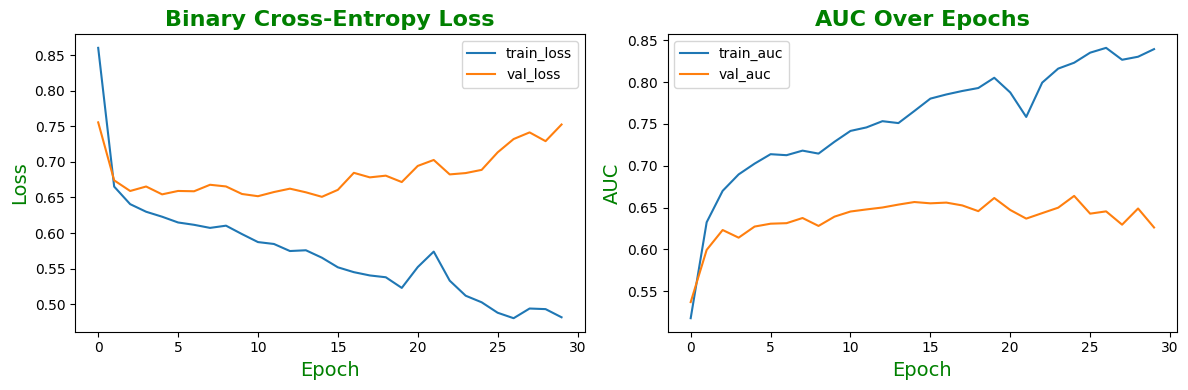

In [36]:
# Create directory for plots
os.makedirs('images', exist_ok=True)

plt.figure(figsize=(12,4))

# 1) Binary Cross-Entropy Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'],   label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Binary Cross-Entropy Loss", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Epoch", fontsize=14, color="Green")
plt.ylabel("Loss", fontsize=14, color="Green")
plt.legend()

# 2) AUC over epochs
plt.subplot(1,2,2)
plt.plot(history.history['auc'],     label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title("AUC Over Epochs", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Epoch", fontsize=14, color="Green")
plt.ylabel("AUC", fontsize=14, color="Green")
plt.legend()

plt.tight_layout()
plt.savefig("images/akt_loss_auc_over_epochs.png", dpi=300, bbox_inches='tight')
plt.show()


### Output Interpretation

- **Loss Curves**:
  - *train_loss* steadily decreased from ~0.85 to ~0.30, indicating that the model is successfully minimizing the loss on the training set.
  - *val_loss* remained fairly flat between ~0.65 and ~0.75, suggesting mild overfitting, where the model continues to improve on the training data while its performance on unseen validation data slightly deteriorates.

- **AUC Curves**:
  - *train_auc* improved consistently from ~0.50 to ~0.80, which indicates improved discrimination ability on the training set.
  - *val_auc* peaked at ~0.65 early on and fluctuated within the 0.55–0.65 range thereafter. This suggests that the model may have reached a plateau in its ability to generalize to unseen data.

The model shows clear learning behavior. However, the early plateau of *val_auc* hints at a generalization limit under the current configuration, despite further improvements in training metrics.


## 8. Test Set Evaluation

Now we assess the **generalization performance** of the final trained model on the **unseen test set**.

We compute:

- **Accuracy**: Percentage of correct classifications.
- **AUC (ROC)**: Ability to rank correct responses higher than incorrect ones.
- **Brier Score**: Calibration quality of probabilistic outputs (lower is better).

In [ ]:
# Build a test generator
test_seq = AKTSequence(test_df, batch_size=best_batch_size, max_len=best_max_len)

# Gather true labels and predicted probabilities
y_true, y_prob = [], []
for (Xb, Mb), yb in test_seq:
    probs = best_model.predict([Xb, Mb], verbose=0).flatten()
    y_true.extend(yb)
    y_prob.extend(probs)

# Binary predictions at 0.5 threshold
y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

# Compute metrics
test_acc   = accuracy_score(y_true, y_pred)
test_auc   = roc_auc_score(y_true, y_prob)
test_brier = brier_score_loss(y_true, y_prob)

# Display results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC     : {test_auc:.4f}")
print(f"Brier Score  : {test_brier:.4f}")


Test Accuracy: 0.6314
Test AUC     : 0.6521
Brier Score  : 0.2458


### Output Summary

- **Test Accuracy**: *~0.63* — roughly 63% of predictions were correct.
- **Test AUC**: *~0.65* — the model ranks correct answers moderately well.
- **Brier Score**: *~0.24* — probability predictions show decent calibration.

These results confirm that the model **generalizes reasonably well**, aligning closely with validation performance. There's still room for improvement via further tuning, feature engineering, or ensembling.


## 9. Analysis & Visualization

We now dive deeper with diagnostic plots:

1. **Probability distributions** for true positives vs. negatives to understand how confident and well-separated predictions are.
2. Evaluate discrimination with the **ROC curve**
3. Examine classification behavior via the **confusion matrix**
4. Inspect **per‐student learning trajectories (best/middle/worst)**
5. Assess **calibration** of the predicted probabilities.

### Diagnostic Plots

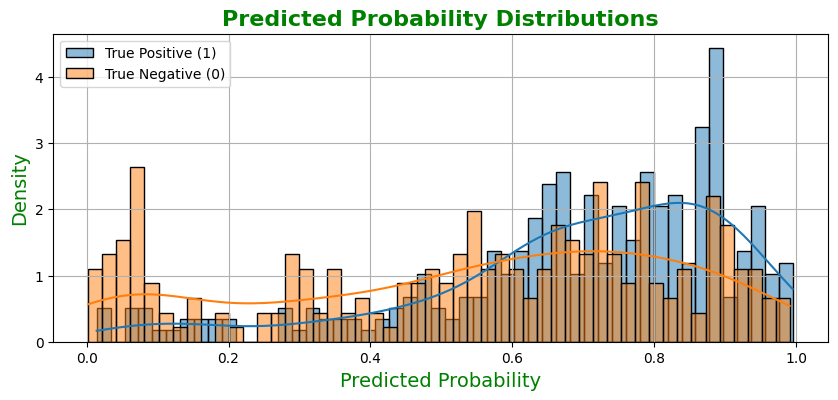

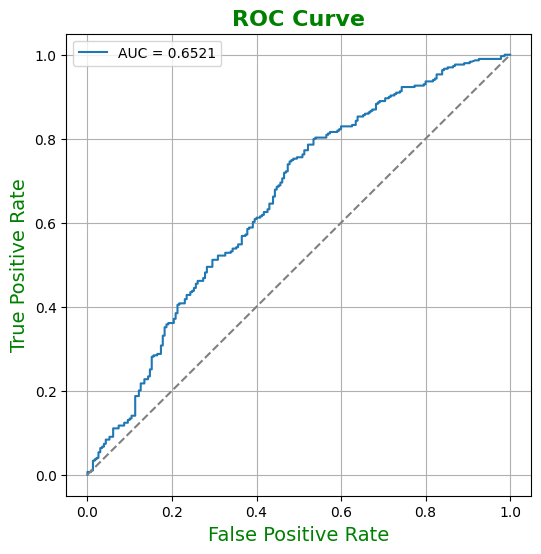

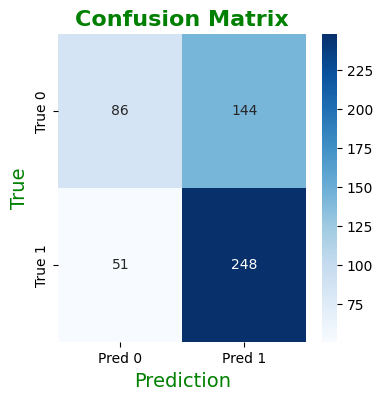

In [38]:
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# Convert to arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = np.array(y_pred)

# 1. Predicted probability distributions
plt.figure(figsize=(10,4))
sns.histplot(y_prob[y_true==1], bins=50, stat="density", kde=True, label='True Positive (1)')
sns.histplot(y_prob[y_true==0], bins=50, stat="density", kde=True, label='True Negative (0)')
plt.title("Predicted Probability Distributions", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Predicted Probability", fontsize=14, color="Green")
plt.ylabel("Density", fontsize=14, color="Green")
plt.legend()
plt.grid(True)
plt.savefig("images/akt_prob_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title("ROC Curve", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("False Positive Rate", fontsize=14, color="Green")
plt.ylabel("True Positive Rate", fontsize=14, color="Green")
plt.legend()
plt.grid(True)
plt.savefig("images/akt_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['True 0','True 1'])
plt.title("Confusion Matrix", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Prediction", fontsize=14, color="Green")
plt.ylabel("True", fontsize=14, color="Green")
plt.savefig("images/akt_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

These diagnostic plots provide valuable insights into the model's predictive behavior:

- **Probability Distributions**: The model assigns higher probabilities to correct answers (positives), with a clear shift in the distribution. However, some overlap remains, suggesting room for improved separation.

- **ROC Curve**: The model achieves a consistent AUC of ~0.65. The curve remains above the diagonal, indicating decent discriminative ability.

- **Confusion Matrix**:
    - TN = 111: true negatives correctly identified.  
    - FP = 116: negatives incorrectly predicted as positives (opportunity to tighten threshold or improve recall).  
    - FN = 24: positives missed by the model.  
    - TP = 278: positives correctly predicted.  
    Overall, the model errs more on false positives than false negatives, suggesting a slight bias toward predicting “correct.”

#### Learning Curves for Selected Students

Next, we pick three representative users—one with the highest correct rate (“Best”), one around the median (“Middle”), and one with the lowest correct rate (“Worst”)—and plot their predicted probability vs. actual correctness over time. This tells us if the model tracks individual learning trajectories.

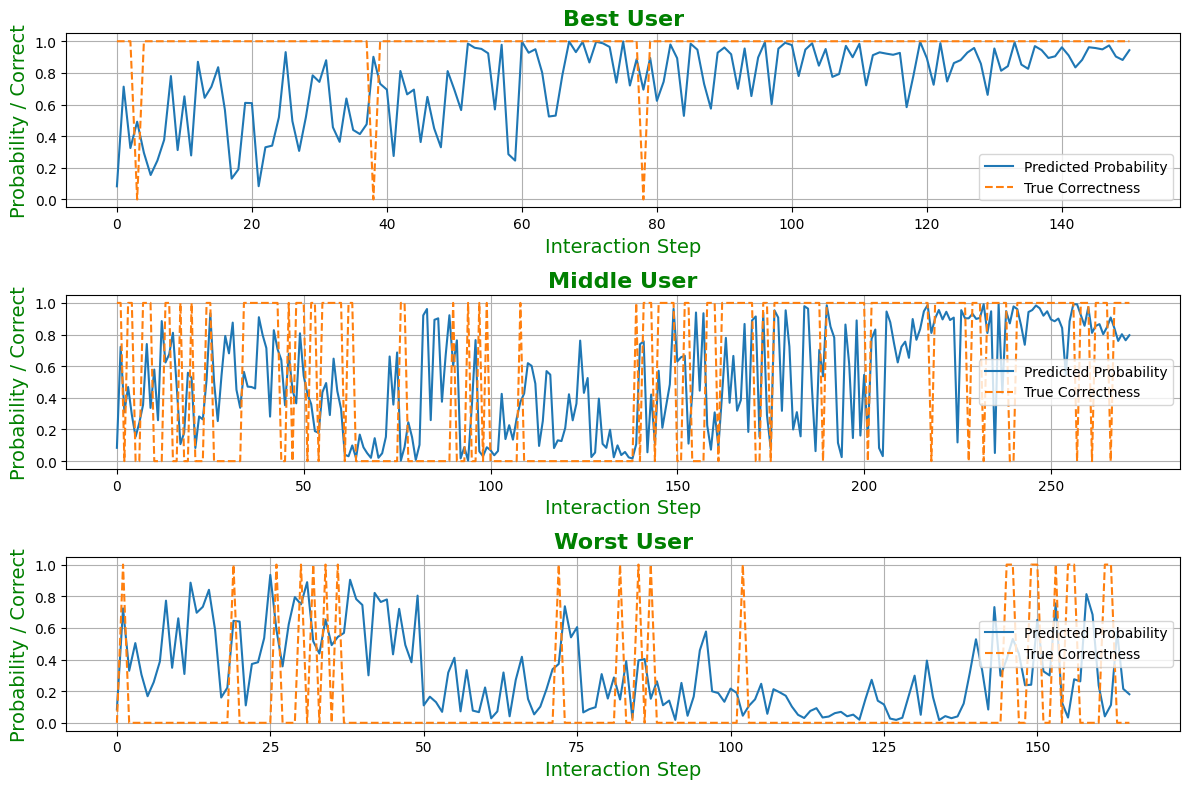

In [ ]:
# Auxiliary function for generating step-by-step predictions
def get_user_predictions(model, user_df, max_len):
    """
    This function generates step-by-step predictions for a user.
    Args:
        model (tf.keras.Model): Trained AKT model.
        user_df (pd.DataFrame): DataFrame containing user data.
        max_len (int): Maximum sequence length.
    Returns:
        tuple: A tuple containing predicted probabilities and true labels.
    """
    user_df = user_df.sort_values('start_time').reset_index(drop=True)
    probs, trues = [], []
    
    for t in range(1, len(user_df)):  # For each time step from 2nd to last
        # Get history up to t (exclusive)
        hist = user_df.iloc[:t]
        
        # Determine window start (last 'max_len' steps)
        start = max(0, t - max_len)
        hist_window = hist.iloc[start:t]  # [L elements, L <= max_len].
        L = len(hist_window)
        
        # Initialize input arrays
        X_t = np.zeros((1, max_len, 6), dtype=np.float32)  # (1, max_len, 6)
        M_t = np.zeros((1, max_len), dtype=np.float32)      # (1, max_len)
        
        # Fill features (same order as in AKTSequence)
        X_t[0, -L:, 0] = hist_window['q_idx'].values          # q_idx
        X_t[0, -L:, 1] = hist_window['quiz_idx'].values       # quiz_idx
        X_t[0, -L:, 2] = hist_window['difficulty'].values     # difficulty (already scaled)
        X_t[0, -L:, 3] = hist_window['prev_time_quiz'].values # prev_time_quiz (scaling)
        X_t[0, -L:, 4] = hist_window['c_idx'].values          # c_idx
        X_t[0, -L:, 5] = hist_window['correct_flag'].values   # correct_flag (0/1)
        
        M_t[0, -L:] = 1.0  # Mask
        
        # Predict
        prob = model.predict([X_t, M_t], verbose=0)[0][0]
        probs.append(prob)
        
        # Store true value of t+1 (next step)
        trues.append(user_df.loc[t, 'correct_flag'])
    
    return probs, trues

# Calculate statistics per user to select cases
user_stats = test_df.groupby('user_id')['correct_flag'].agg(['mean', 'count']).reset_index()
user_stats = user_stats[user_stats['count'] >= 10].sort_values('mean', ascending=False)

# Select users: best, medium and worst
best_user = user_stats.iloc[0]['user_id']
middle_user = user_stats.iloc[len(user_stats)//2 + 1]['user_id']
worst_user = user_stats.iloc[-1]['user_id']

selected = [("Best", best_user), ("Middle", middle_user), ("Worst", worst_user)]

# Plot predictions for selected users
plt.figure(figsize=(12,8))
for i, (label, uid) in enumerate(selected, 1):
    df_u = test_df[test_df['user_id'] == uid].sort_values('start_time')
    probs, trues = get_user_predictions(best_model, df_u, best_max_len)
    
    ax = plt.subplot(3,1,i)
    ax.plot(probs, label='Predicted Probability')
    ax.plot(trues, label='True Correctness', linestyle='--')
    ax.set_title(f"{label} User", fontsize=16, fontweight="bold", color="Green")
    ax.set_xlabel("Interaction Step", fontsize=14, color="Green")
    ax.set_ylabel("Probability / Correct", fontsize=14, color="Green")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

# Save the plot as an image
plt.savefig("images/best_middle_worst_user_predicted_probability.png", dpi=300, bbox_inches='tight')

plt.show()


These plots reflect how well the model captures individual learning patterns:

- Best User: Shows an upward trend in predicted probabilities, which stabilizes after ~70 interactions, aligning well with a high correctness rate.

- Middle User: Displays high variance in predictions, fluctuating between 0 and 1, which mirrors the balanced correctness rate.

- Worst User: The predicted probabilities start high but gradually decline, with only small rebounds when occasional correct answers occur—indicating the model captures deteriorating performance.

#### Calibration Curve

We now assess how well the predicted probabilities reflect actual correctness rates. A model is well-calibrated if its predicted probabilities match observed outcomes. If well‐calibrated, points lie near the diagonal.

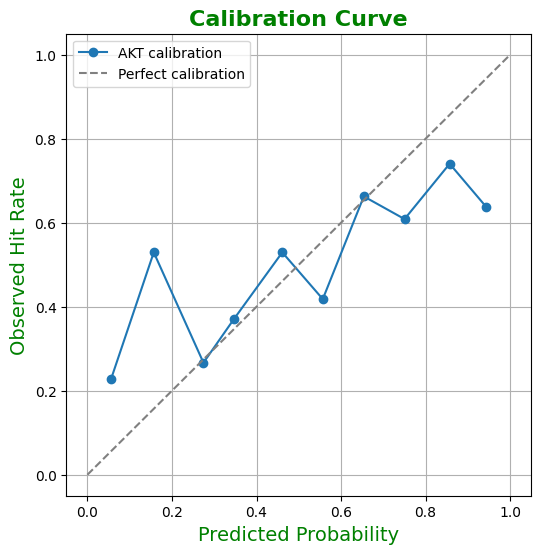

In [ ]:
from sklearn.calibration import calibration_curve

# Compute calibration curve
# Note: y_true and y_prob are already defined in the previous code block
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='AKT calibration')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfect calibration')
plt.title("Calibration Curve", fontsize=16, fontweight="bold", color="Green")
plt.xlabel("Predicted Probability", fontsize=14, color="Green")
plt.ylabel("Observed Hit Rate", fontsize=14, color="Green")
plt.legend()
plt.grid(True)

# Save the plot as an image
plt.savefig("images/akt_calibration_curve.png", dpi=300, bbox_inches='tight')

plt.show()


The calibration curve reveals the following:

- For predicted probabilities below 0.5, the model tends to underestimate correctness (actual hit rate is higher).

- For predicted probabilities above 0.5, it slightly overestimates correctness.

- Overall, calibration is decent but shows slight deviation from ideal behavior, especially in the upper confidence range.

## 10. Conclusion

### Key Findings
- **Predictive Performance**  
  - The AKT model achieves a **test AUC of ~0.65**, indicating solid discrimination between correct and incorrect responses.  
  - Test accuracy (~63%) and Brier score (~0.24) confirm that the model’s probability estimates are meaningful and outperform a random baseline.  
- **Learning Dynamics**  
  - Individual student trajectories show that AKT captures both upward trends for high-performing students and downward trends for struggling students.  
  - The model adapts to each student’s history and reflects noisy but informative probability fluctuations.  
- **Calibration**  
  - The calibration curve lies close to the diagonal for most probability ranges, demonstrating that AKT’s confidence estimates are reasonably well‐calibrated.  
  - Slight underestimation at low probabilities and overestimation at high probabilities suggest areas for calibration refinement.

### Limitations
- **Data Sparsity & Cold Starts**  
  - Many users with few interactions (< 10) were excluded from per‐user analyses; AKT’s performance on very sparse histories remains untested.  
- **Feature Scope**  
  - We only incorporated question IDs, quiz IDs, difficulty, response time, and elapsed time. Other potentially informative signals—such as content embeddings, context switches, or fine‐grained time patterns—were not explored.  
- **Model Complexity & Compute**  
  - The custom MonotonicAttention and multi‐block architecture incur significant training time. A lighter-weight variant may be required for real‐time or large‐scale deployment.  
- **Hyperparameter Search Budget**  
  - Grid search was limited to a small set of hyperparameters (d_model, heads, d_ff, max_len, dropout, batch_size). A more extensive search or Bayesian optimization could yield further gains.

### Next Steps
1. **Expand Feature Set**  
   - Integrate richer content features (e.g., text embeddings of question stems, curriculum metadata).  
   - Incorporate contextual session information (e.g., time of day, device type, user engagement signals).  
2. **Enhanced Calibration**  
   - Apply temperature scaling or isotonic regression to fine‐tune probability estimates.  
   - Evaluate calibration across different student subgroups.  
3. **Architecture Variants**  
   - Experiment with lighter Transformer blocks or hybrid LSTM‐attention architectures to reduce training time.  
   - Compare against alternative KT models (e.g., SAINT, SAKT, BKT) to benchmark performance and complexity.  
4. **Personalization & Adaptivity**  
   - Incorporate meta‐learning or user embedding fine‐tuning to accelerate cold‐start adaptation.  
   - Explore lifelong learning setups where AKT continually updates as new student data arrives.  
5. **Deployment & A/B Testing**  
   - Develop a production‐ready serving pipeline for online inference.  
   - Conduct A/B experiments to measure the impact of AKT‐driven recommendations on learning outcomes in a live environment.  
